To execute the code, enter it into a cell and click the "Play" button on the cell's left or press "Shift + Enter" on your keyboard. The code will run in the Colab environment, with results displayed directly under the cell. For running the entire notebook, select "Runtime" and choose "Run all.



In [1]:
!pip install nltk # Install NLTK for natural language processing tasks
!pip install numpy # Install NumPy for numerical computations
!pip install pandas # Install pandas for data manipulation and analysis
!pip install scikit-learn # Install scikit-learn for machine learning
!pip install torch # Install PyTorch for deep learning
!pip install tqdm # Install tqdm for progress bars during loops
!pip install matplotlib # Install matplotlib to plot accuracy plots
!pip install xlrd # Install xlrd for reading Excel files


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import libraries

import logging
import math
import re
import multiprocessing
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import nltk
import numpy as np
import pandas as pd
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

import random
import matplotlib.pyplot as plt

from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')

multiprocessing.set_start_method('fork')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rimma_vakhreeva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rimma_vakhreeva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rimma_vakhreeva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/rimma_vakhreeva/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/rimma_vakhreeva/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
EMD_DIM = 200  # Set embedding dimension size

class GloveEmbeddingsIndex:
    # Path to the GloVe embeddings file, formatted to include embedding dimension in filename
    GLOVE_FILE_PATH = Path("./") / f"./glove.twitter.27B.{EMD_DIM}d.txt"

    def __init__(self):
        self.cached_embeddings = {}  # Cache for storing loaded embeddings to avoid re-reading the file
        self._index = self._build_glove_file_index()  # Build an index for fast lookup of embeddings
        # Generate embeddings for special tokens: beginning of sentence, end of sentence, and unknown words
        self._bos_emb = np.random.uniform(-0.25, 0.25, EMD_DIM)
        self._eos_emb = np.random.uniform(-0.25, 0.25, EMD_DIM)
        self.unknown_emb = np.random.uniform(-0.25, 0.25, EMD_DIM)

    def get_embedding_for_word(self, word: str) -> np.ndarray:
        word = word.lower()  # Normalize word to lowercase
        # Return special embeddings for beginning and end of sentence tokens
        if word == "<bos>":
            return self._bos_emb
        elif word == "<eos>":
            return self._eos_emb
        # Return cached embedding if available
        elif word in self.cached_embeddings:
            return self.cached_embeddings[word]

        # Look up word position in index and read its embedding from file
        position = self._index.get(word.lower(), None)
        if position is not None:
            with open(self.GLOVE_FILE_PATH, 'r', encoding='utf-8') as file:
                # Skip lines to the word's position
                _ = [file.readline() for _ in range(position)]
                line_split = file.readline().split()
                found_word, embedding = line_split[0], line_split[1:]
                # Ensure the found word matches the requested word
                assert found_word == word, f"Invalid logic: found_word={found_word} != request_word={word}"
                # Convert string embeddings to float and cache
                embedding = np.array([float(val) for val in embedding], dtype=np.float32)
                self.cached_embeddings[word] = embedding
                return embedding
        else:
            # Return and cache unknown word embedding if word not found
            self.cached_embeddings[word] = self.unknown_emb
            return self.unknown_emb

    def _build_glove_file_index(self) -> Dict[str, int]:
        # Create an index mapping words to their line numbers in the GloVe file for quick access
        logging.info("Loading glove embedding index")
        index = {}
        with open(self.GLOVE_FILE_PATH, 'r', encoding='utf-8') as file:
            for position, line in enumerate(file):
                line_split = line.split()
                word = line_split[0]
                # Preload embeddings into cache
                embedding = np.array([float(val) for val in line_split[1:]], dtype=np.float32)
                index[word] = position
                self.cached_embeddings[word] = embedding
        return index

    def vocab(self) -> List[str]:
        # Return a list of all words for which embeddings are available
        return list(self._index.keys())


In [4]:
from collections import Counter


class TweetItem:
    # Dictionary mapping slang acronyms to their expanded forms
    SLANG_ACRONYMS = {
        'idts': 'I do not think so', 'icymi': 'In Case You Missed It', 'lol': 'laugh out loud', 'brb': 'be right back',
        'btw': 'by the way', 'imo': 'in my opinion', 'imho': 'in my humble opinion', 'smh': 'shaking my head',
        'tbh': 'to be honest', 'rofl': 'rolling on the floor laughing', 'bff': 'best friends forever',
        'nvm': 'never mind', 'idk': 'I do not know', 'tbt': 'throwback Thursday', 'fomo': 'fear of missing out',
        'ftw': 'for the win', 'gg': 'good game', 'irl': 'in real life', 'jk': 'just kidding',
        'lmao': 'laughing my ass off', 'omg': 'oh my god', 'ppl': 'people', 'thx': 'thanks',
        'ttyl': 'talk to you later', 'yolo': 'you only live once'
    }
    # Dictionary mapping emoji to their described emotions
    EMOJI_EMOTIONS = {
        ':)': 'happy', ':(': 'sad', '😊': 'smiling face with smiling eyes', '😂': 'face with tears of joy',
        '😢': 'crying face',
        '😠': 'angry face', '❤️': 'red heart', '👍': 'thumbs up', '👎': 'thumbs down', '😱': 'face screaming in fear',
        '🎉': 'party popper', '💔': 'broken heart', '😍': 'smiling face with heart-eyes', '😒': 'unamused face',
        '😉': 'winking face',
        '😜': 'winking face with tongue', '🙏': 'folded hands', '😐': 'neutral face', '😴': 'sleeping face',
        '💤': 'sleeping symbol',
        '😡': 'pouting face', '🤔': 'thinking face', '🤣': 'rolling on the floor laughing', '😇': 'smiling face with halo',
        '🤗': 'hugging face', '😔': 'pensive face', '😏': 'smirking face', '🥳': 'partying face', '🤯': 'exploding head',
        '🥺': 'pleading face', '🤩': 'star-struck', '😓': 'downcast face with sweat', '😖': 'confounded face',
        '🥰': 'smiling face with hearts', '😘': 'face blowing a kiss', '😷': 'face with medical mask'
    }
    # Mapping of contractions and negative references to their expanded forms
    NEGATIVE_REF_REPLACEMENTS = {
        "won't": "will not", "can't": "cannot", "n't": " not", "isn't": "is not",
        "aren't": "are not", "wasn't": "was not", "weren't": "were not", "haven't": "have not",
        "hasn't": "has not", "hadn't": "had not", "doesn't": "does not", "don't": "do not",
        "didn't": "did not", "won’t": "will not", "can’t": "cannot", "shan't": "shall not",
        "shan’t": "shall not", "shouldn't": "should not", "shouldn’t": "should not", "couldn't": "could not",
        "couldn’t": "could not", "mightn't": "might not", "mightn’t": "might not", "mustn't": "must not",
        "mustn’t": "must not"
    }

    def __init__(self, text: str):
        assert type(text) is str, f"Invalid data: {text}"
        self.text = text  # Original tweet text
        # Statistics for analyzing the text
        self._stats = {
            "emoji_num": 0,  # Number of emojis
            "hashtag_num": self.text.count("#"),  # Number of hashtags
            "negation_num": 0,  # Number of negative references
            "capitalized_num": sum(int(l.isupper()) for l in self.text),  # Number of capitalized letters
        }
        # Normalized text after preprocessing
        self.normalized_text = self._normalize(self.text)
        # Tokenized version of the normalized text
        self.normalized_tokens = self._tokenize(self.normalized_text)

    @staticmethod
    # Dummy method for POS tagging (not implemented in the snippet)
    def _tag_pos(text: str) -> Dict[str, int]:
        tagged = nltk.pos_tag(nltk.word_tokenize(text))
        return Counter([pos for _, pos in tagged]).values()

    @staticmethod
    #  Calculate Pointwise Mutual Information (PMI) for a word with respect to sentiment
    def pmi(word: str, sentiment: str, tokens: List[str]) -> float:
        word_count = tokens.count(word)
        sentiment_count = 1 if sentiment in tokens else 0
        word_sentiment_count = 1 if word in tokens and sentiment in tokens else 0
        total_words = len(tokens)

        p_word = word_count / total_words
        p_sentiment = sentiment_count / total_words
        p_word_sentiment = word_sentiment_count / total_words

        pmi_score = math.log2((p_word_sentiment + 1e-8) / ((p_word + 1e-8) * (p_sentiment + 1e-8)))
        return pmi_score

    @staticmethod
    # Compute sentiment polarity scores for each token
    def sentiment_polarity_scores(tokens: List[str]) -> List[float]:
        scores = []
        for token in tokens:
            synsets = list(swn.senti_synsets(token))
            if synsets:
                pos_scores = [synset.pos_score() for synset in synsets]
                neg_scores = [synset.neg_score() for synset in synsets]
                avg_pos_score = sum(pos_scores) / len(pos_scores)
                avg_neg_score = sum(neg_scores) / len(neg_scores)
                score = avg_pos_score - avg_neg_score
            else:
                pos_pmi = TweetItem.pmi(token, "positive", tokens)
                neg_pmi = TweetItem.pmi(token, "negative", tokens)
                score = pos_pmi - neg_pmi
            scores.append(score)
        return scores

    # Remove URLs from the text
    def _remove_urls(self, text: str) -> str:
        return re.sub(
            r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
            'an url', text
        )

    # Remove numbers from the text
    def _remove_numbers(self, text: str) -> str:
        return re.sub(r'\d+', '', text)
    # Replace negative references in the text with their expanded forms
    def _replace_negative_references(self, text: str) -> str:
        for key, value in self.NEGATIVE_REF_REPLACEMENTS.items():
            self._stats["negation_num"] += text.count(key)
            text = text.replace(key, value)
        return text

    # Expand acronyms and slang in the text
    def _expand_acronyms_slang(self, text: str) -> str:
        words = text.split()
        expanded_words = [
            self.SLANG_ACRONYMS[word.lower()] if word.lower() in self.SLANG_ACRONYMS else word
            for word in words
        ]
        return ' '.join(expanded_words)

    # Remove stopwords from the text
    def _remove_stopwords(self, text: str) -> str:
        stop_words = set(stopwords.words('english'))
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    # Replace emoticons and emoji in the text with words
    def _replace_emoticons_emoji(self, text: str) -> str:
        for key, value in self.EMOJI_EMOTIONS.items():
            self._stats["emoji_num"] += text.count(key)
            text = text.replace(key, value)
        return text

    # Normalize the tweet text by applying preprocessing functions
    def _normalize(self, text: str) -> str:
        text = self._remove_urls(text)
        text = self._remove_numbers(text)
        text = self._replace_negative_references(text)
        text = self._expand_acronyms_slang(text)
        text = self._remove_stopwords(text)
        text = self._replace_emoticons_emoji(text)
        return text

    # Tokenize the text into words
    def _tokenize(self, text: str) -> List[str]:
        return ["<bos>"] + word_tokenize(text, language="english", preserve_line=False) + ["<eos>"]

    # Generate n-grams from the tokenized text
    def n_grams_vocab_counter(self, ngram_range: Tuple = (1, 2)) -> Counter:
        all_vocab = None
        for n in ngram_range:
            if all_vocab is None:
                all_vocab = Counter(nltk.ngrams(self.normalized_tokens, n))
            else:
                all_vocab = all_vocab + Counter(nltk.ngrams(self.normalized_tokens, n))
        return all_vocab

    # Generate a feature vector for the tweet using embeddings and other features
    def generate_feature_vector(
            self,
            embedding_index: GloveEmbeddingsIndex,
            max_length: int,
            vocab: List[str],
            ngram_range: Tuple = (1, 2),
    ) -> np.ndarray:
        word_embeddings = np.stack([embedding_index.get_embedding_for_word(t) for t in self.normalized_tokens], axis=0)
        pad_size = max_length - len(self.normalized_tokens)
        if len(word_embeddings) < max_length:
            padded = np.array([embedding_index.unknown_emb] * pad_size, dtype=np.float32)
            word_embeddings = np.concatenate([word_embeddings, padded], axis=0)
            sentiment_scores_vector = np.array(self.sentiment_polarity_scores(self.normalized_tokens) + ([-1] * pad_size),
                                               dtype=np.float32).reshape((-1, 1))
        else:
            word_embeddings = word_embeddings[:max_length]
            sentiment_scores_vector = np.array(self.sentiment_polarity_scores(self.normalized_tokens)[:max_length],
                                               dtype=np.float32).reshape((-1, 1))

        local_vocab_counter = dict(self.n_grams_vocab_counter(ngram_range))
        unigram_bigram_vector = np.array([local_vocab_counter.get(v, 0) for v in vocab], dtype=np.float32)

        twitter_specific_vector = np.array([
            self._stats["emoji_num"], self._stats["hashtag_num"], self._stats["negation_num"],
            self._stats["capitalized_num"],  # self._stats["pos"],
        ])

        extra_data = np.concatenate([unigram_bigram_vector, twitter_specific_vector]).reshape((1, -1))
        extra_data = np.repeat(extra_data, (max_length,), axis=0)
        return np.concatenate((word_embeddings, sentiment_scores_vector, extra_data), axis=1).astype(np.float32)


In [5]:
def load_stsgd(path: Path = Path("./") / "STSGd_.xls") -> Tuple[np.ndarray, np.ndarray]:
    # Internal function to convert sentiment ratings to a normalized scale
    def _convert_ratings(data):
        # Calculate the difference between positive and negative mean scores
        difference = data["mean pos"] - data["mean neg"]
        # Normalize the difference to fit within a 0-4 scale
        normalized_diff = (difference + 4) / 2
        # Round and ensure values are within the 0-4 range
        return normalized_diff.map(lambda x: int(round(max(0.0, min(4.0, x)))))

    # Load the dataset from an Excel file
    data = pd.read_excel(path)
    # Extract tweets and their corresponding normalized sentiment ratings
    return data["tweet"].tolist(), _convert_ratings(data).tolist()

def load_sentiment_140(path: Path = Path("./") / "training.1600000.processed.noemoticon.csv") -> Tuple[np.ndarray, np.ndarray]:
    # Load the dataset from a CSV file, ignoring encoding errors
    data = pd.read_csv(path, encoding_errors="ignore", header=None)
    # Rename columns for clarity
    data = data.rename(columns={0: 'target', 1: 'ids', 2: 'date', 3: 'flag', 4: 'user', 5: 'text'})
    # Extract tweets and their corresponding sentiment labels
    return data["text"].tolist(), data["target"].tolist()

# Dictionary mapping dataset names to their respective loading functions
ds_readers = {
    "STSGd": load_stsgd,  # Function to load the STSGd dataset
    "Sentiment140": load_sentiment_140  # Function to load the Sentiment140 dataset
}


In [6]:
class Dataset:
    def __init__(
            self,
            ngram_range: Tuple = (1, 2),  # Specifies the range of n-grams to be considered
            tweet_max_tokens_num: int = 128,  # Maximum number of tokens per tweet
            datasets: Tuple = ("STSGd", "Sentiment140"),  # Names of datasets to load
            top_k_for_ngram: int = 512,  # Number of top n-grams to retain
            limit: Optional[int] = None,  # Limit on the number of tweets to load
            seed: int = 42,  # Random seed for shuffling
            test_split_ratio: float = 0.2  # Ratio for splitting data into training and test sets
    ):
        self.ngram_range = ngram_range
        self.tweet_max_tokens_num = tweet_max_tokens_num
        self.is_train = True  # Flag to toggle between training and evaluation modes
        self.x, self.y = [], []  # Lists to store tweet texts and their labels
        self.random = random.Random(seed)  # Random number generator
        self.emb_index = GloveEmbeddingsIndex()  # Instance of GloveEmbeddingsIndex for accessing embeddings

        # Load data from specified datasets
        for ds in datasets:
            x, y = ds_readers[ds]()
            self.x += x
            self.y += y

        # Shuffle the data
        indices = list(range(len(self.x)))
        self.random.shuffle(indices)
        self.x = [self.x[i] for i in indices]
        self.y = [self.y[i] for i in indices]

        # Apply limit if specified
        if limit is not None:
            self.x = self.x[:limit]
            self.y = self.y[:limit]

        # Normalize and tokenize tweets
        self.x = [TweetItem(text) for text in tqdm.tqdm(self.x, desc="creating dataset")]
        # Retrieve global vocabulary from the dataset
        self.global_vocab: Counter = self._retrieve_global_vocab()
        # Identify the most common vocabularies
        self.most_common_vocab: List[Tuple] = [el for el, _ in self.global_vocab.most_common(top_k_for_ngram)]

        # Split data into training and test sets
        indices = list(range(len(self.x)))
        self.random.shuffle(indices)
        split_idx = set(indices[:int(len(self.x) * test_split_ratio)])
        self.train_x = [row for i, row in enumerate(self.x) if i not in split_idx]
        self.train_y = [row for i, row in enumerate(self.y) if i not in split_idx]
        self.test_x = [row for i, row in enumerate(self.x) if i in split_idx]
        self.test_y = [row for i, row in enumerate(self.y) if i in split_idx]

    def eval(self):
        # Switch to evaluation mode
        self.is_train = False

    def train(self):
        # Switch to training mode
        self.is_train = True

    def _retrieve_global_vocab(self):
        # Calculate global vocabulary from the dataset, limiting to the first 10,000 tweets for performance
        c = Counter()
        for row in tqdm.tqdm(self.x[:10000], desc="calculating global vocab"):
            c += row.n_grams_vocab_counter(self.ngram_range)
        return c

    @property
    def emb_dim(self) -> int:
        # Get embedding dimension
        return self[0][0].shape[1]

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        # Get item by index, for training or testing
        x, y = (self.train_x[idx], self.train_y[idx]) if self.is_train else (self.test_x[idx], self.test_y[idx])
        # Convert labels to categorical values
        if y == 0:
            y = 0
        elif y in (1, 2, 3):
            y = 1
        else:
            y = 2
        # Generate feature vector for the tweet
        vec = x.generate_feature_vector(embedding_index=self.emb_index,
                                        max_length=self.tweet_max_tokens_num,
                                        vocab=self.most_common_vocab,
                                        ngram_range=self.ngram_range)
        return vec, np.array(y, dtype=np.int64)

    def __len__(self) -> int:
        # Return the length of the dataset, depending on training or evaluation mode
        return len(self.train_x) if self.is_train else len(self.test_x)


In [7]:
class GloVeDCNN(nn.Module):
    def __init__(self, emb_dim, num_filters, filter_sizes, num_classes, dropout_rate):
        super(GloVeDCNN, self).__init__()
        # Define a series of convolutional layers based on the specified filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(emb_dim, num_filters, filter_size) for filter_size in filter_sizes
        ])
        # A fully connected layer that outputs the predictions for each class
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        # Dropout layer to prevent overfitting by randomly dropping units during training
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Rearrange tensor dimensions for convolution operations
        x = x.permute(0, 2, 1)
        # Apply ReLU activation function to the output of each convolutional layer
        x = [torch.relu(conv(x)) for conv in self.convs]
        # Apply max pooling to each convolution output to reduce its dimensionality
        x = [torch.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in x]
        # Concatenate all the convolutional layer outputs
        x = torch.cat(x, dim=1)
        # Apply dropout for regularization
        x = self.dropout(x)
        # Pass the final concatenated tensor through the fully connected layer to get class scores
        x = self.fc(x)
        return x


In [8]:
def plot_acc(train_accuracy, test_accuracy):
    epochs = list(range(1, len(train_accuracy) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_accuracy, label='Test Accuracy', marker='x')
    plt.title('Train vs Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def train(
        num_filters: int = 256,
        filter_sizes: Tuple = (3, 4, 5, 12),
        dropout_rate: float = 0.05,
        num_classes: int = 3,
        test_split_ratio: float = 0.1,
        batch_size: int = 2048,
        num_epochs: int = 10,
        learning_rate: float = 0.005,
        lr_step_size: int = 1,
        lr_gamma: float = 0.6,
        datasets: Tuple = ("STSGd", "Sentiment140"),
        num_workers: int = 16,
        cuda: bool = True,
        ds_limit_size: Optional[int] = None
):
    # Create the model, dataset, and data loader
    ds = Dataset(datasets=datasets, seed=69, test_split_ratio=test_split_ratio, limit=ds_limit_size)
    dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    model = GloVeDCNN(ds.emb_dim, num_filters, filter_sizes, num_classes, dropout_rate)
    if cuda:
        model = model.cuda()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

    # Training loop
    train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        ds.train()  # Set dataset to training mode
        model.train()  # Set model to training mode for dropout, batchnorm, etc.
        total_predictions, correct_predictions = 0, 0  # Initialize counters for accuracy calculation
        for inputs, targets in tqdm.tqdm(dataloader, desc=f"Epoch {epoch}: "):
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs)  # Forward pass: compute predicted outputs by passing inputs to the model
            total_predictions += targets.size(0)  # Count total predictions for accuracy calculation
            # Count how many predictions match the targets
            correct_predictions += (outputs.argmax(dim=1) == targets).sum()
            loss = criterion(outputs, targets)  # Calculate the loss
            loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step()  # Perform a single optimization step (parameter update)
        train_accuracy = correct_predictions / total_predictions  # Calculate training accuracy
        train_accs.append(train_accuracy.cpu().numpy())

        ds.eval()  # Set dataset to evaluation mode
        model.eval()  # Set model to evaluation mode
        total_predictions, correct_predictions = 0, 0  # Reset counters for accuracy calculation
        with torch.no_grad():  # Disable gradient calculation for evaluation, saving memory and computations
            test_data = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=16, drop_last=True)
            for inputs, targets in tqdm.tqdm(test_data, desc=f"Testing"):
                if cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                outputs = model(inputs)  # Forward pass: compute predicted outputs by passing inputs to the model
                test_loss = criterion(outputs, targets)  # Calculate the loss
                total_predictions += targets.size(0)  # Count total predictions for accuracy calculation
                # Count how many predictions match the targets
                correct_predictions += (outputs.argmax(dim=1) == targets).sum()
        test_accuracy = correct_predictions / total_predictions  # Calculate test accuracy
        test_accs.append(test_accuracy.cpu().numpy())
        # Print epoch summary
        print(f"Epoch [{epoch + 1}/{num_epochs}], Learning Rate: {scheduler.get_last_lr()[0]:.6f}, "
              f"Train Loss: {loss.item():.4f}, Test loss: {test_loss.item():.4f}, "
              f"Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}")
        scheduler.step()  # Update the learning rate
    return train_accs, test_accs

Train Sentiment140 dataset


calculating global vocab: 100%|██████████| 10000/10000 [00:11<00:00, 906.76it/s]
/Users/rimma_vakhreeva/PycharmProjects/twits_classifier/venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Testing: 100%|██████████| 625/625 [1:25:44<00:00,  8.23s/it]


Epoch [1/10], Learning Rate: 0.005000, Train Loss: 0.4731, Test loss: 0.4542, Train accuracy: 0.7844, Test accuracy: 0.7910


Testing: 100%|██████████| 625/625 [1:46:35<00:00, 10.23s/it]


Epoch [2/10], Learning Rate: 0.003000, Train Loss: 0.4369, Test loss: 0.4255, Train accuracy: 0.8033, Test accuracy: 0.8044


Testing: 100%|██████████| 625/625 [1:46:37<00:00, 10.24s/it]  


Epoch [3/10], Learning Rate: 0.001800, Train Loss: 0.4179, Test loss: 0.4324, Train accuracy: 0.8140, Test accuracy: 0.8053


Testing: 100%|██████████| 625/625 [1:36:40<00:00,  9.28s/it]


Epoch [4/10], Learning Rate: 0.001080, Train Loss: 0.4040, Test loss: 0.4337, Train accuracy: 0.8241, Test accuracy: 0.8053


Testing: 100%|██████████| 625/625 [1:44:20<00:00, 10.02s/it]


Epoch [5/10], Learning Rate: 0.000648, Train Loss: 0.4140, Test loss: 0.4409, Train accuracy: 0.8326, Test accuracy: 0.8053


Testing: 100%|██████████| 625/625 [1:40:26<00:00,  9.64s/it]


Epoch [6/10], Learning Rate: 0.000389, Train Loss: 0.3654, Test loss: 0.4688, Train accuracy: 0.8393, Test accuracy: 0.8037


Testing: 100%|██████████| 625/625 [1:43:33<00:00,  9.94s/it]


Epoch [7/10], Learning Rate: 0.000233, Train Loss: 0.3421, Test loss: 0.5008, Train accuracy: 0.8439, Test accuracy: 0.8021


Testing: 100%|██████████| 625/625 [1:42:29<00:00,  9.84s/it]


Epoch [8/10], Learning Rate: 0.000140, Train Loss: 0.3403, Test loss: 0.5154, Train accuracy: 0.8467, Test accuracy: 0.8016


Testing: 100%|██████████| 625/625 [1:41:57<00:00,  9.79s/it]


Epoch [9/10], Learning Rate: 0.000084, Train Loss: 0.2793, Test loss: 0.5235, Train accuracy: 0.8488, Test accuracy: 0.8009


Testing: 100%|██████████| 625/625 [1:41:55<00:00,  9.78s/it]


Epoch [10/10], Learning Rate: 0.000050, Train Loss: 0.3189, Test loss: 0.5288, Train accuracy: 0.8499, Test accuracy: 0.8009


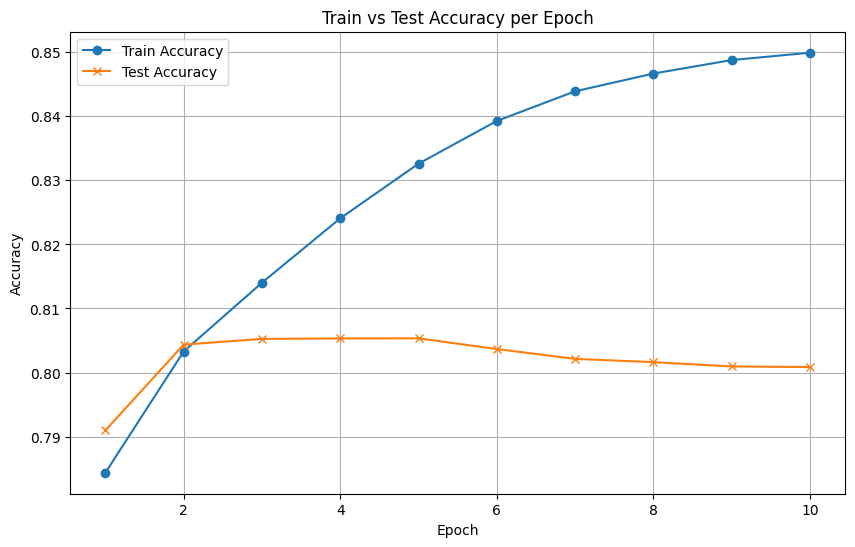

In [11]:
print("Train Sentiment140 dataset")
train_acc, test_acc = train(
    dropout_rate=0.05,
    batch_size=256,
    datasets=("Sentiment140",),
    cuda=False,
    ds_limit_size=1600000
)
plot_acc(train_acc, test_acc)